In [1]:
%run 'graph functions.ipynb'

# Metric reconstruction problem

### Cluster

(3286, 2)


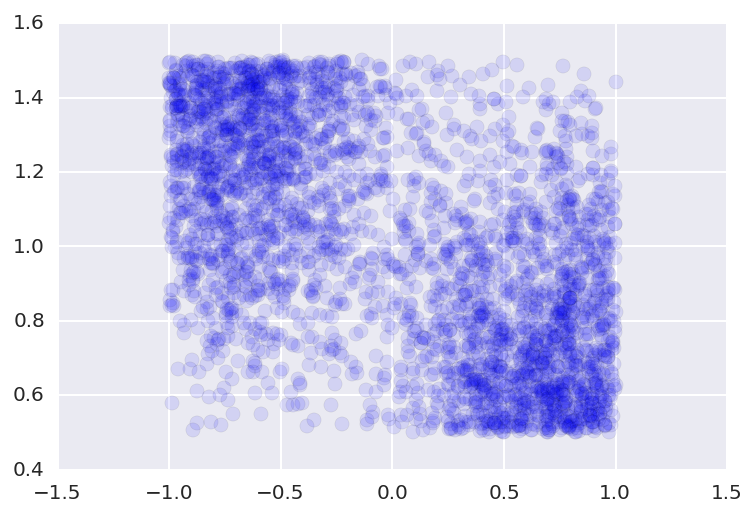

In [2]:
np.random.seed(1)

n=18000
k=200

scs=0.4
x1 = np.random.normal(loc=np.array((-0.75,1.5)),scale=scs,size=(n/4,2))
x2 = np.random.normal(loc=np.array((0.75,0.5)),scale=scs,size=(n/4,2))
xc = np.vstack((x1,x2))

xc = xc[(np.abs(xc[:,0]) < 1) & (np.abs(xc[:,1]-1)<0.5),:]
print xc.shape

plt.figure()
plt.scatter(xc[:,0],xc[:,1],alpha=0.1,s=50)


In [3]:
nbrs, adj = fit_knn(xc, k)
pi, dest, epsest = fit_graph(adj, d=2)

In [4]:
sps = get_sps(adj, epsest)
spd = np.power(0.5*(sps+sps.T),2)

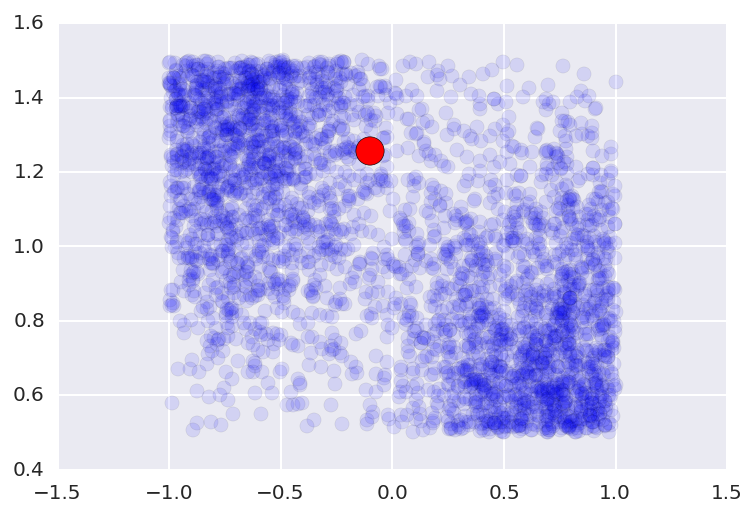

In [5]:
plt.figure()
orig=0
plt.scatter(xc[:,0],xc[:,1],alpha=0.1,s=50)
plt.scatter(xc[orig,0],xc[orig,1],s=200,c='red')

In [6]:
nb = adj_to_nblist(adj)
orig = 0
nsamples = 10000
runtime = 50000
hittimes = fast_hit_time(orig,nsamples,runtime, nb)
exphit = np.dot(hittimes,np.arange(runtime))/nsamples + runtime * (nsamples-np.sum(hittimes,1))/nsamples
exphit

array([ 15972.9386,   9722.2698,  40229.962 , ...,  13072.6052,
        16786.4383,   3475.6759])

In [7]:
beta = 1
weighthit1 = -np.log(np.dot(hittimes,np.exp(-beta*np.arange(runtime)))/nsamples + np.exp(-beta*runtime) * (nsamples-np.sum(hittimes,1))/nsamples)/beta

beta = 0.01
weighthit01 = -np.log(np.dot(hittimes,np.exp(-beta*np.arange(runtime)))/nsamples + np.exp(-beta*runtime) * (nsamples-np.sum(hittimes,1))/nsamples)/beta

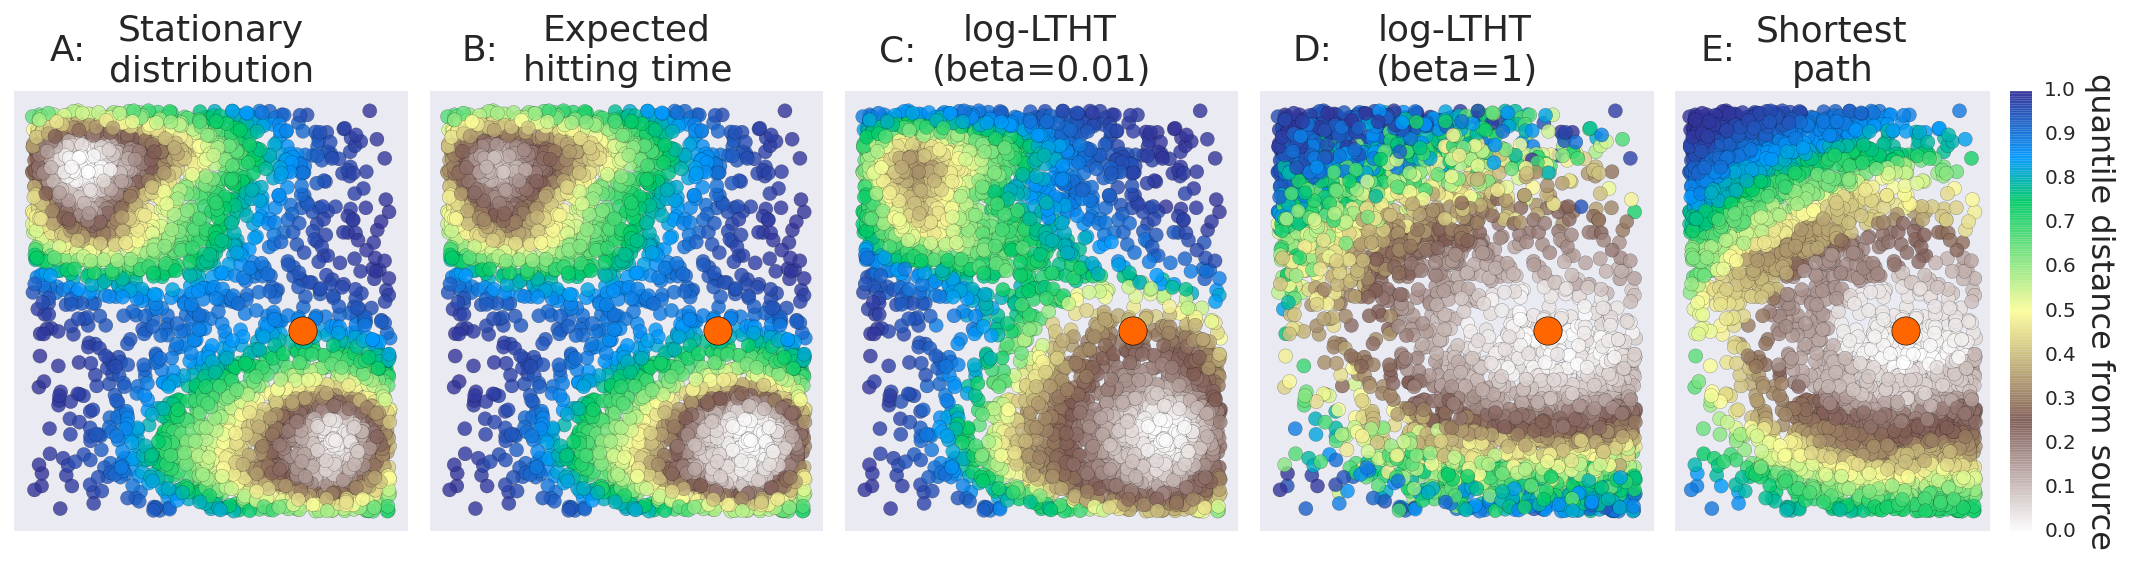

In [8]:
cname ='terrain_r'
orig=0

cmlist = [pi, -exphit, -weighthit01,  -weighthit1, -sps[orig,:]]
cmlist = [sp.stats.rankdata(-cm)/float(len(cm)) for cm in cmlist]
cmnames = ['Stationary\ndistribution','Expected\nhitting time','log-LTHT\n(beta=0.01)','log-LTHT\n(beta=1)','Shortest\npath']
headers = ['A','B','C','D','E']

fig, axes = plt.subplots(nrows=1, ncols=len(cmlist), figsize=(15, 4), sharey=True, dpi=600)

for i in xrange(len(cmlist)):
    plt.figure()
    splot = axes[i].scatter(xc[:,1]-1,xc[:,0],c=cmlist[i],cmap=mpl.cm.get_cmap(cname),lw=0.1,s=50,alpha=0.8)
    axes[i].scatter(xc[orig,1]-1,xc[orig,0],c='#FF6600',s=200,alpha=1)
    axes[i].set_title(cmnames[i], fontsize =18)
    axes[i].set_ylim(np.array((-1,1))*1.1)
    axes[i].set_xlim(np.array((-1,1))*0.55)
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
    axes[i].text(-0.45,1.25,headers[i]+':',fontsize=18, variant='small-caps')

cbar= fig.colorbar(splot)
cbar.set_ticks(np.arange(0,1.1,0.1))
cbar.set_label('quantile distance from source',labelpad=20,rotation=270,fontsize=16)

fig.tight_layout()

#Verifying some properties of the chain

## Brownian-motion correction

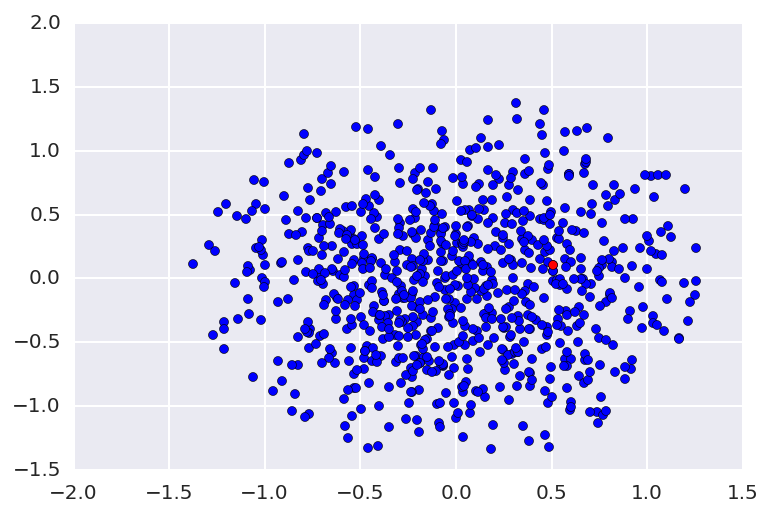

In [9]:
n=2000
k=30

np.random.seed(1)
theta=np.random.uniform(low=0,high=2*math.pi,size=n)

x1 = np.random.normal(loc=0.0,scale=0.5,size=(500,2))
x2 = np.random.normal(loc=0,scale=1.0,size=(500,2))

xc = np.vstack((x1,x2))

xc=xc[np.sum(xc**2,1)<=2,:]

plt.figure()
plt.scatter(xc[:,0],xc[:,1],c='b')
orig=0
plt.scatter(xc[orig,0],xc[orig,1],c='r')

In [10]:
nbrs, adj = fit_knn(xc, k)
pi, dest, epsest = fit_graph(adj, d=2)

In [11]:
radj = reweighted_walk(dest,epsest, xc, nbrs)

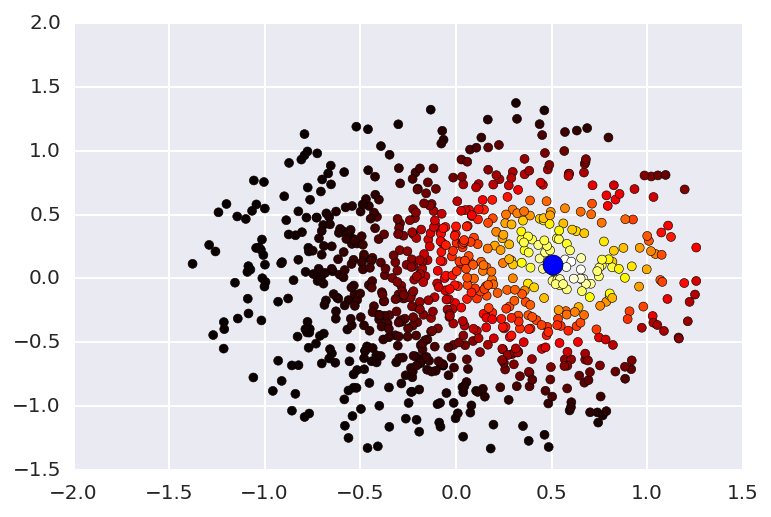

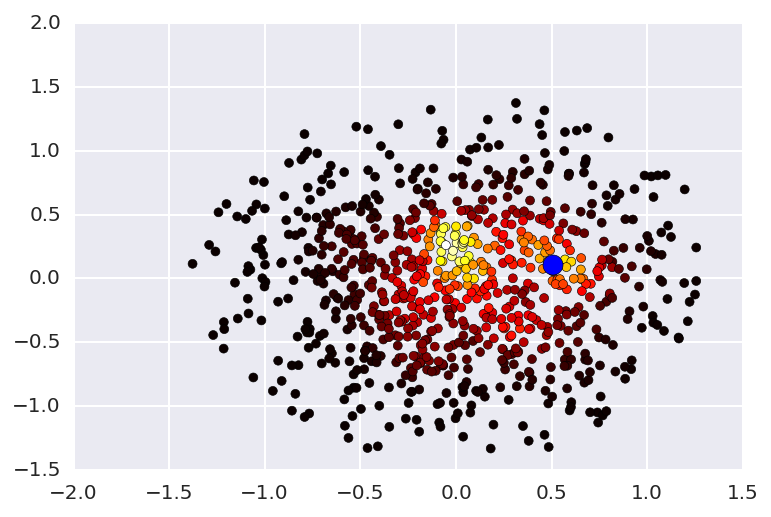

In [12]:
init=np.zeros(xc.shape[0])
init[orig]=1

for k in xrange(40):
    init= np.dot(init,radj)
plt.figure()
plt.scatter(xc[:,0],xc[:,1],c=init/np.power(epsest,2),cmap=mpl.cm.get_cmap('hot'))
plt.scatter(xc[orig,0],xc[orig,1],c='b',s=100)

init=np.zeros(xc.shape[0])
init[orig]=1

for k in xrange(40):
    init= np.dot(init,adj)
plt.figure()
plt.scatter(xc[:,0],xc[:,1],c=init/np.power(epsest,2),cmap=mpl.cm.get_cmap('hot'))
plt.scatter(xc[orig,0],xc[orig,1],c='b',s=100)

In [13]:
subsel=np.random.randint(xc.shape[0],size=200)
tadjpoints = np.array([slow_hitting_time(radj,orig,j,3000) for j in subsel])
tpoints = np.array([slow_hitting_time(adj,orig,j,3000) for j in subsel])

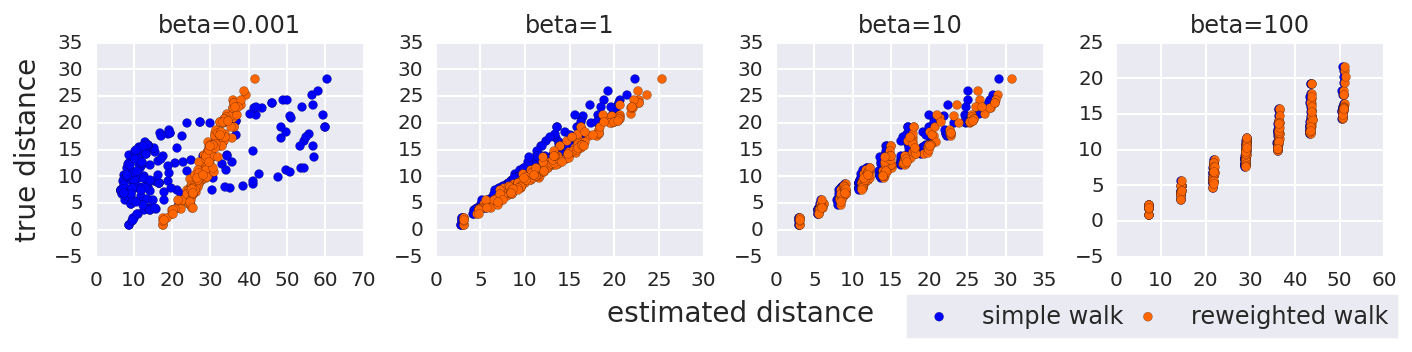

In [14]:
dists= np.sqrt(np.sum((xc[subsel,:]-xc[orig,:])**2,1))*15

betalist = [0.001, 1, 10, 100]

fig = plt.figure(figsize=(10,2.5))
i=1
ax = fig.add_subplot(1,1,1)
for beta in betalist:
    axsub = fig.add_subplot(1,4,i)
    nwalk=axsub.scatter(ltht(tpoints,beta)/np.sqrt(2*beta),dists,c='blue',lw=0.1,s=20)
    bwalk=axsub.scatter(ltht(tadjpoints,beta)/np.sqrt(2*beta),dists,c='#FF6600',lw=0.1,s=20)
    axsub.set_title('beta='+str(beta))
    i=i+1
fig.tight_layout()
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.patch.set_facecolor('none')

ax.set_xlabel('estimated distance',fontsize=14)
ax.set_ylabel('true distance',fontsize=14)

ax.legend([nwalk, bwalk], ["simple walk", "reweighted walk"],bbox_to_anchor=(1.02, -0.12),ncol=2,fontsize=12,columnspacing=0.01)

## More extensive simulations

In [15]:
nseq = [500, 1000, 5000]
kseq = [20, 50, 100]

maxt=20000
nrun=50000
orig=1

xset = []
bmset = []
rwset = []

for i in xrange(len(nseq)):
    print i
    np.random.seed(1)
    x1 = np.random.normal(loc=0.0,scale=0.5,size=(nseq[i],2))
    x2 = np.random.normal(loc=0,scale=1.0,size=(nseq[i],2))
    xc = np.vstack((x1,x2))
    xc=xc[np.sum(xc**2,1)<=2,:]
    nbrs, adj = fit_knn(xc, kseq[i])
    pi, dest, epsest = fit_graph(adj, d=2)
    radj = reweighted_walk(dest,epsest, xc, nbrs)
    nbs = [np.nonzero(radj[i,:])[0].tolist() for i in xrange(radj.shape[0])]
    wnbs = [radj[i,nbs[i]].tolist() for i in xrange(radj.shape[0])]
    xset.append(xc)
    bmhitt=weight_hit_time(orig, maxt, nrun, nbs, wnbs)
    rwhitt=weight_hit_time(orig, maxt, nrun, nbs)
    bmset.append(bmhitt)
    rwset.append(rwhitt)

0
1
2


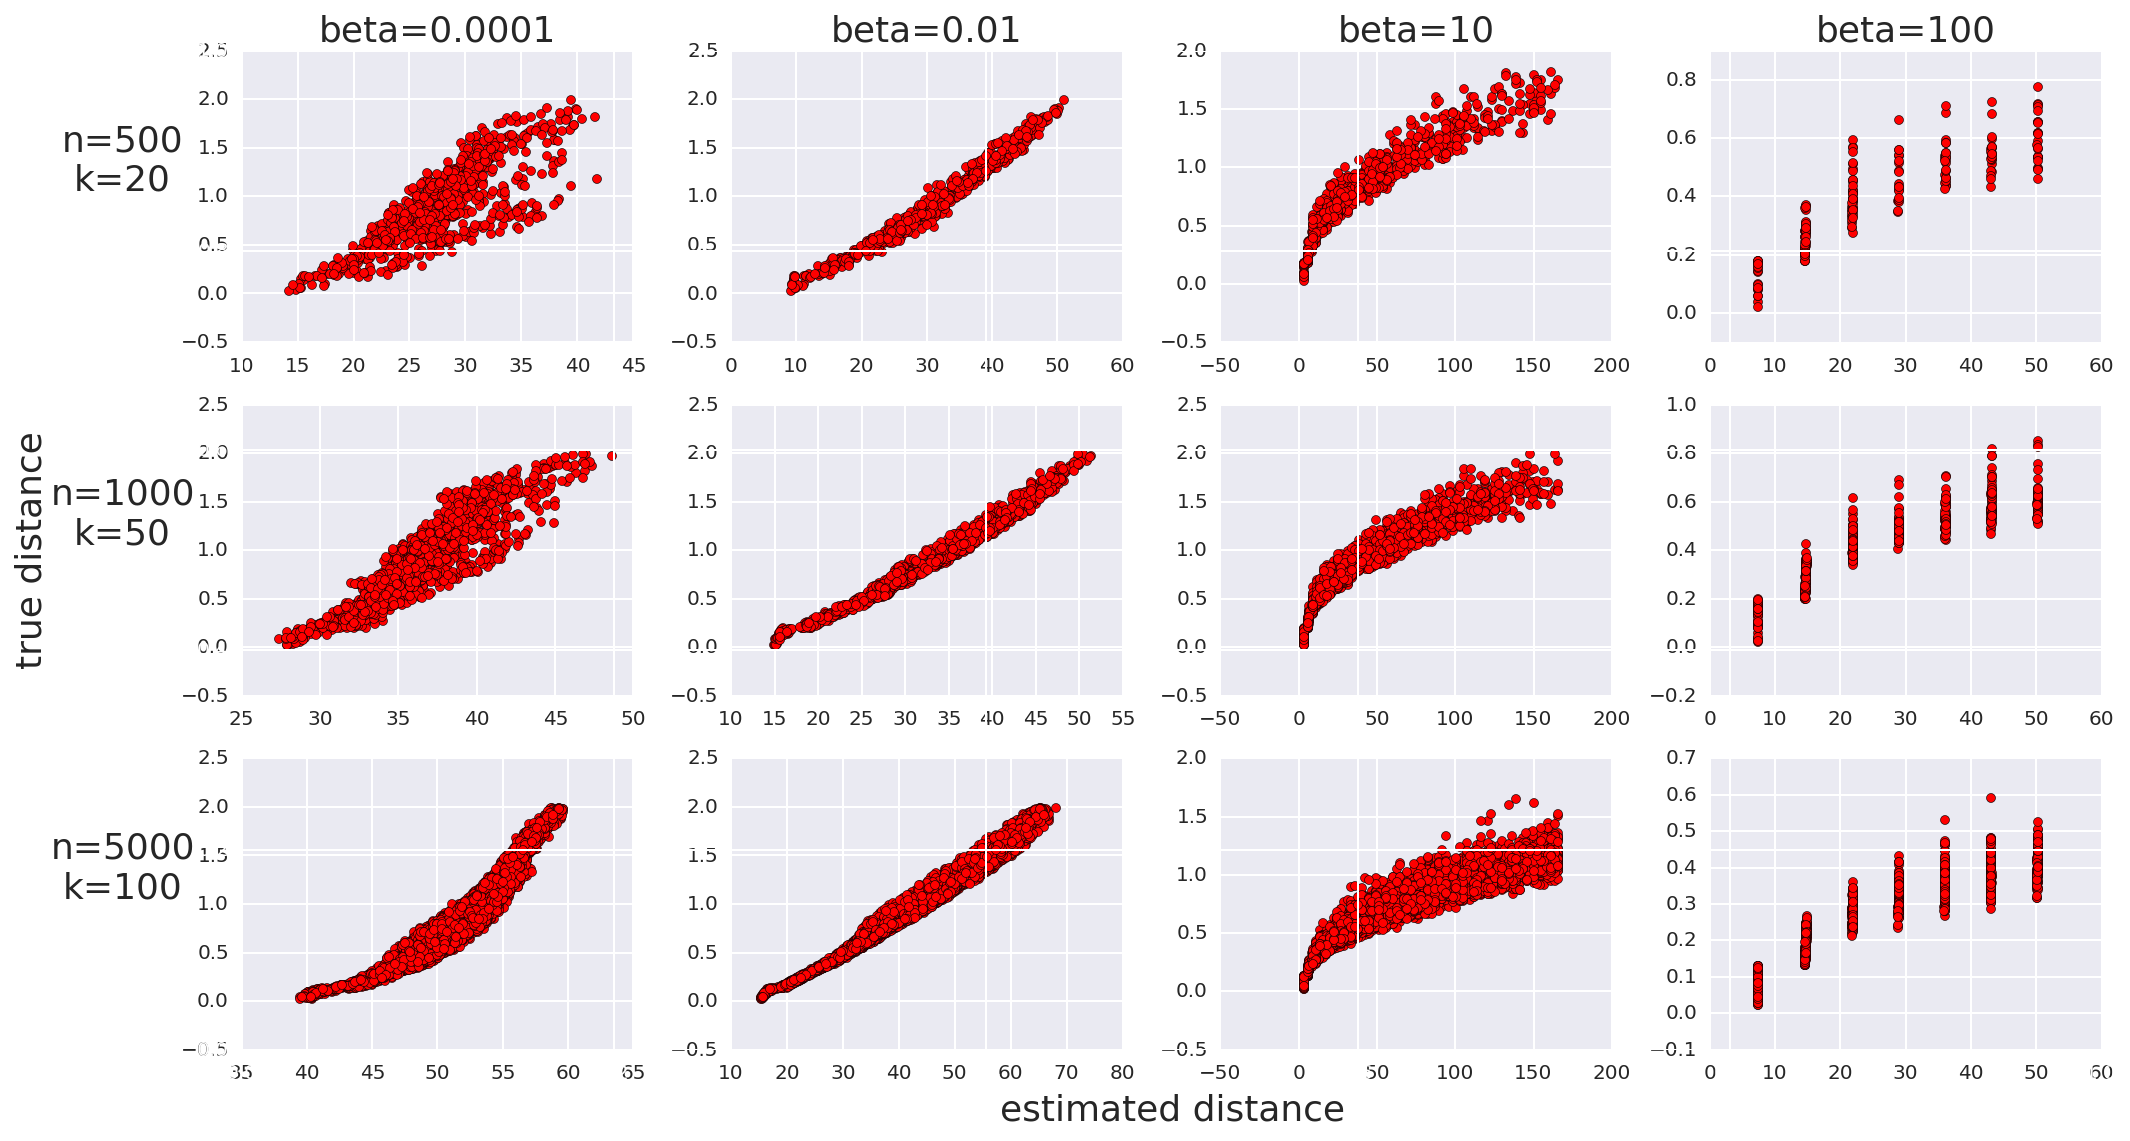

In [16]:
betalist = [0.0001, 0.01, 10, 100]
orig=1
fig, axes = plt.subplots(nrows=len(nseq), ncols=len(betalist), figsize=(15, 8))

#fig = plt.figure(figsize=(15,3)
ax = fig.add_subplot(1,1,1)
for i in xrange(len(nseq)):
    xc = xset[i]
    dists = np.sqrt(np.sum((xc[orig,:]-xc)**2,1))
    bmhitt = bmset[i]
    j=0
    for beta in betalist:
        ltt=ltht(bmhitt,beta,0)/np.sqrt(2*beta)
        bwalk = axes[i][j].scatter(np.delete(ltt,orig,0),np.delete(dists,orig,0),c='red')
        if(i==0):
            axes[i][j].set_title('beta='+str(beta),fontsize=18)
        j=j+1

rows=['n='+str(nseq[i])+'\nk='+str(kseq[i]) for i in xrange(len(nseq))]
for axsub, row in zip(axes[:,0], rows):
    axsub.set_ylabel(row, rotation=0,fontsize=18)
    axsub.yaxis.labelpad = 30
        
fig.tight_layout()
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.patch.set_facecolor('none')

ax.set_xlabel('estimated distance',fontsize=18)
ax.set_ylabel('true distance',fontsize=18,labelpad = 75)

## 'Real-world' graphs

In [17]:
data_dir = '/cluster/thashim/graphs/'

## High-energy physics citation network

Get the dataset from 
http://www.cs.cornell.edu/projects/kddcup/datasets.html

In [18]:
data_dir = '/cluster/thashim/graphs/'

*Note* - the data download blocks have been turned into raw-cells so that they do not redownload the data every time. Switch them back to python blocks on first run

In [19]:
cgraph = igraph.Graph.Read_Edgelist(data_dir+"hep-th-citations").simplify()

In [20]:
deg=cgraph.degree(type="out")
sel = np.nonzero(np.array(deg) > 5)[0]
dense=cgraph.subgraph(sel)
clusters=dense.clusters().subgraphs()
csizes = [cluster.vcount() for cluster in clusters]
bigcluster = clusters[np.argmax(csizes)]
#bigcluster.simplify()

In [21]:
igraph.summary(bigcluster)

IGRAPH D--- 11042 222027 -- 


In [22]:
def resource_alloc_single(graph, v1):
    deg = 1.0/np.array(graph.degree(type='in'))
    neisets = [np.array(graph.neighbors(i,mode='out')) for i in xrange(graph.vcount())]
    tr = np.zeros(graph.vcount())
    for v2 in xrange(graph.vcount()):
        common_neis = np.intersect1d(neisets[v1],neisets[v2])
        if len(common_neis) > 0:
            tr[v2] = np.sum(deg[common_neis])
    return tr

In [23]:
nsamples = 2000
runtime = 10000
beta = 0.2

nedges = 200

np.random.seed(0)
edgelist = bigcluster.get_edgelist()
edgesamp = np.random.randint(len(edgelist),size=nedges)
rmat = np.zeros((len(edgesamp), 8))
print edgesamp

[199340  43567 173685 117952 176963 152315  95939  97639  41993 122579
  86293 186098 112420 211543 212038  48600 170584  52620  80186  17089
 163302 150055 108631 220760 101201  82457 137993 169876  67699  70608
 168691   7877  83966 132943  73135 133568 179026 155747 108504  31921
 131869  49811 199827 211854 221607 122144 212929 183561  84665 119423
  41504  49866 215284 123031 125603  11723 174962 148663  58146 108672
 190372  89141  71557 151078 134632 221940  61713  96591  45444  46522
 113183  86904  20737 159719 192425  92217  80163  12134 191607  47883
  86107  63360 182883   9781 150412  27257 147370  12372 135492 111366
  82991  62079 210932 138084   9396   3918   9359 116372 175331 154554
 146199 101261  37237  79701   8752 108101 211113 202403  50624 220255
  40133  93790 186225  62756 124834  90928  81757  84355  99938 179754
  66509 217456 206823 207765  24777 125311  13824 133490 143915  78778
  36223  61570   6521 219234 187966  74659  96990 108483 121426  14254
  5193

In [24]:
for edgesel in xrange(len(edgesamp)):
    if edgesel % 10 == 0:
        print edgesel
    ccopy = bigcluster.copy()
    
    orig = edgelist[edgesamp[edgesel]][0]
    target = edgelist[edgesamp[edgesel]][1]
    
    rmid = ccopy.get_eid(orig,target)
    ccopy.delete_edges(rmid)
    nbs = ccopy.neighborhood()

    hittimes = fast_hit_time(orig,nsamples,runtime, nbs)
    sps = ccopy.shortest_paths(source=orig,mode='out')[0]
    ras = -1*resource_alloc_single(ccopy, orig)
    
    cneighbors=np.intersect1d(np.array(ccopy.neighbors(orig)),np.array(ccopy.neighbors(target)))
    cnvec = -1*np.array([len(np.intersect1d(np.array(v),np.array(ccopy.neighbors(orig,mode='out')))) 
                      for v in ccopy.neighborhood(mode='out')])
    
    exphit = np.dot(hittimes,np.arange(runtime))/nsamples + runtime * (nsamples-np.sum(hittimes,1))/nsamples
    weighthit = -np.log(np.dot(hittimes,np.exp(-beta*np.arange(runtime)))/nsamples 
                        + np.exp(-beta*runtime) * (nsamples-np.sum(hittimes,1))/nsamples)

    rmat[edgesel,:]=np.array([sp.stats.rankdata(sps)[target]/len(sps), 
                              sp.stats.rankdata(exphit)[target]/len(exphit), 
                              sp.stats.rankdata(weighthit)[target]/len(weighthit),
                              sp.stats.rankdata(ras)[target]/len(ras),
                              sp.stats.rankdata(cnvec)[target]/len(cnvec),
                              orig,
                              target,
                              len(cneighbors)
                             ])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


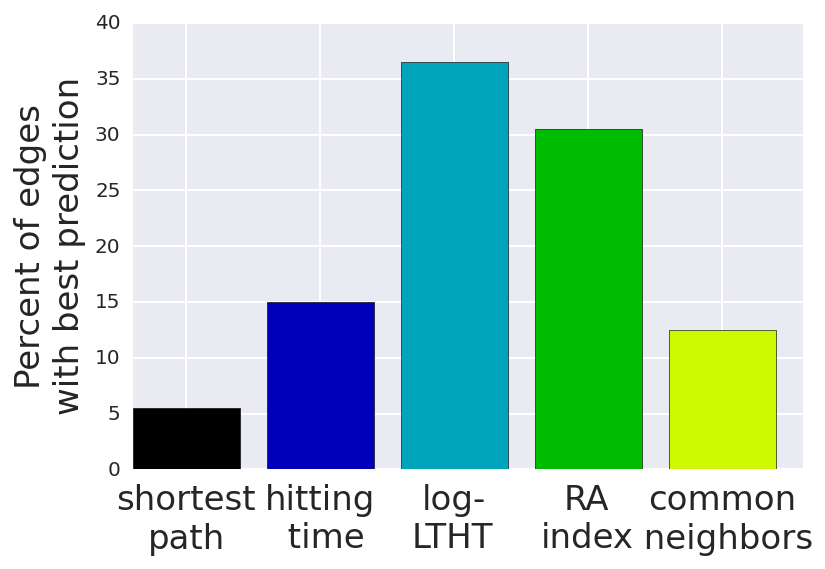

In [25]:
toprank=np.array([np.argmin(rmat[i,0:5]) for i in xrange(rmat.shape[0])])
cols=plt.get_cmap('spectral')(np.arange(6)/6.0)
x1=np.array(('shortest\npath','hitting\n time','log-\nLTHT','RA\nindex','common\n neighbors'))
#sns.set(font_scale=1.5)
fig, ax = plt.subplots()
ax.bar(np.arange(5), np.bincount(toprank)/200.0*100.0,color=cols)
ax.set_ylabel('Percent of edges\nwith best prediction',fontsize=17)
ax.set_xticks(np.arange(5)+0.4)
ax.set_xticklabels(x1,fontsize=17)
#sns.barplot(y=np.bincount(toprank),x=x1,color=cols)


(-8, 0)

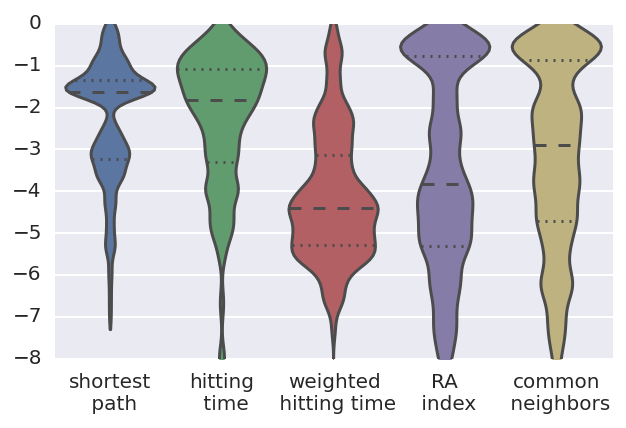

In [26]:
subset=np.nonzero(rmat[:,7] < 5)[0]
plt.figure(figsize=(5,3))
sns.violinplot(np.log(rmat)[:,0:5],bw=0.15,cut=2,names=['shortest\n path','hitting\n time','weighted\n hitting time','RA\n index','common\n neighbors'])
plt.ylim((-8,0))

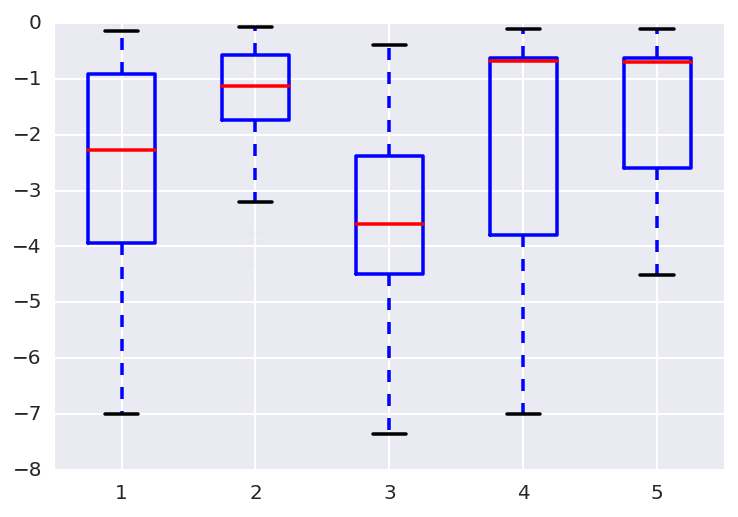

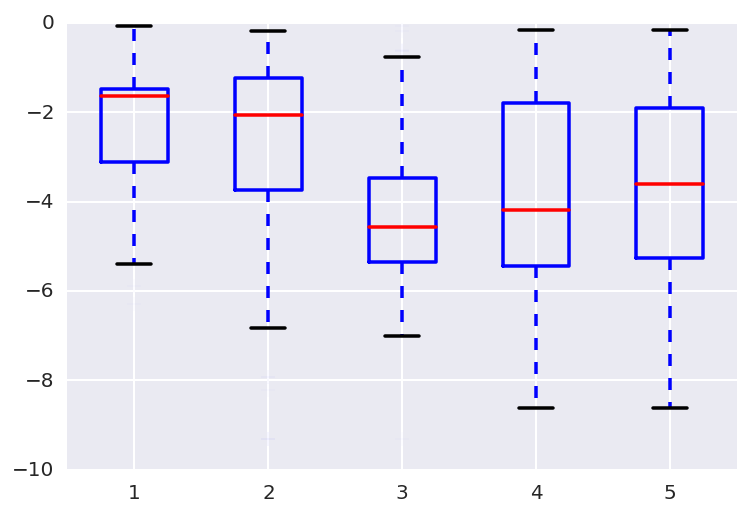

In [27]:
plt.boxplot(np.log(rmat)[np.nonzero(rmat[:,7] <= 4)[0],0:5]);
plt.figure()
plt.boxplot(np.log(rmat)[np.nonzero(rmat[:,7] > 4)[0],0:5]);

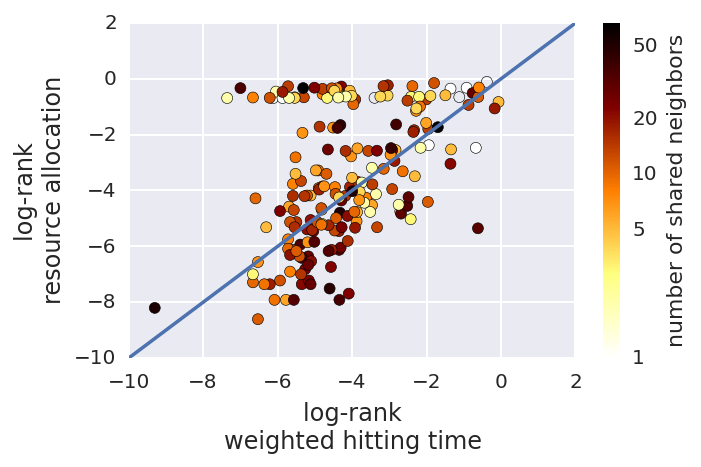

In [28]:
plt.figure(figsize=(5,3))
plt.scatter(np.log(rmat[:,2]),np.log(rmat[:,3]),c=rmat[:,7],cmap=mpl.cm.get_cmap('afmhot_r'),s=30,norm=mpl.colors.LogNorm())

formatter = mpl.ticker.LogFormatter(10, labelOnlyBase=False) 
cb = plt.colorbar(ticks=[1,5,10,20,50], format=formatter)
cb.set_label('number of shared neighbors')

abline()
plt.ylabel('log-rank \nresource allocation',fontsize=12)
plt.xlabel('log-rank \nweighted hitting time',fontsize=12)

## NLP network
http://vlado.fmf.uni-lj.si/pub/networks/data/dic/eat/EATnew.zip

In [29]:
data_dir = '/cluster/thashim/graphs/'

Note - due to how the EAT dataset is structured, the top comment lines in EATnew.net will need to be manually removed.

In [30]:
import igraph
print igraph.__version__
g = igraph.read(data_dir+"EATnew.net",format="pajek").simplify(combine_edges='sum')
igraph.summary(g)

0.6.5
IGRAPH D-W- 23219 325029 -- 
+ attr: id (v), weight (e)


### Prune the graph

In [31]:
deg=g.degree(type="out")
sel = np.nonzero(np.array(deg) > 5)[0]
dense=g.subgraph(sel)
clusters=dense.clusters().subgraphs()
csizes = [len(cluster.vs['id']) for cluster in clusters]
bigcluster = clusters[np.argmax(csizes)]
bigcluster

In [32]:
igraph.summary(bigcluster)

IGRAPH D-W- 7754 246609 -- 
+ attr: id (v), weight (e)


In [33]:
nsamples = 2000
runtime = 10000
beta = 0.2

nedges = 200

np.random.seed(0)
edgelist = bigcluster.get_edgelist()

eweight = np.array(bigcluster.es['weight'])
onelist = np.random.choice(np.nonzero(eweight==1)[0],size=nedges/2)
tenlist = np.random.choice(np.nonzero(eweight>=10)[0],size=nedges/2)

edgesamp = np.concatenate([onelist, tenlist])#np.random.randint(len(edgelist),size=nedges)
rmat = np.zeros((len(edgesamp), 9))
print edgesamp

[ 63956 173304 224133 140876 143390  61687 180119 126676 165205  71371
  77108 117550  24936 240354 220864 159550 148601 120923 202984  99329
 103705  11336 123155 195435 107381 196378 229227 159355  46963 193758
  73130 179499 124187 175540  60973  73208 180750 184524  17019 218814
  85149 159626 130817 105100 222336 197955  90368 141842  66706  68319
 166348 127551  30449 234994 135298 117504  17632  70315 126383  92905
  14110 221388  40215 216922  17963 199212 163622 121723  90929 203118
  13577   5575  13525 171050 227474 215211 148682  54846 116806  12646
 158742  74284  59023 137639  91954 183354 133427 119893 123746 146753
  97527  36435 184073  20062 196256 211896 115500  53283  90147   9353
 135415 167390 196330 217237 146703  57631 158704  92510  54074 120476
 150805 156384 150738  90134 218632   7025 115091  24726 151261 183189
 114939  25802  51880 228139 190248  16673 179052 243946 129785  48909
  65370  83860  30000 143205 116988 181149 224853 155363 173240  82783
 17383

In [34]:
for edgesel in xrange(len(edgesamp)):
    if edgesel % 10 == 0:
        print edgesel
    ccopy = bigcluster.copy()
    
    orig = edgelist[edgesamp[edgesel]][0]
    target = edgelist[edgesamp[edgesel]][1]
    
    rmid = ccopy.get_eid(orig,target)
    ccopy.delete_edges(rmid)
    nbs = ccopy.neighborhood()

    hittimes = fast_hit_time(orig,nsamples,runtime, nbs)
    sps = ccopy.shortest_paths(source=orig,mode='out')[0]
    ras = -1*resource_alloc_single(ccopy, orig)
    
    cneighbors=np.intersect1d(np.array(ccopy.neighbors(orig)),np.array(ccopy.neighbors(target)))
    cnvec = -1*np.array([len(np.intersect1d(np.array(v),np.array(ccopy.neighbors(orig,mode='out')))) 
                      for v in ccopy.neighborhood(mode='out')])
    
    exphit = np.dot(hittimes,np.arange(runtime))/nsamples + runtime * (nsamples-np.sum(hittimes,1))/nsamples
    weighthit = -np.log(np.dot(hittimes,np.exp(-beta*np.arange(runtime)))/nsamples 
                        + np.exp(-beta*runtime) * (nsamples-np.sum(hittimes,1))/nsamples)
    
    nbs = bigcluster.neighborhood()
    hittimes = fast_hit_time(orig,nsamples,runtime, nbs)
    weighthit2 = -np.log(np.dot(hittimes,np.exp(-beta*np.arange(runtime)))/nsamples 
                        + np.exp(-beta*runtime) * (nsamples-np.sum(hittimes,1))/nsamples)

    rmat[edgesel,:]=np.array([sp.stats.rankdata(sps)[target]/len(sps), 
                              sp.stats.rankdata(exphit)[target]/len(exphit), 
                              sp.stats.rankdata(weighthit)[target]/len(weighthit),
                              sp.stats.rankdata(ras)[target]/len(ras),
                              sp.stats.rankdata(cnvec)[target]/len(cnvec),
                              sp.stats.rankdata(weighthit2)[target]/len(weighthit2),
                              orig,
                              target,
                              len(cneighbors)
                             ])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [35]:
eweights=np.array([eweight[bigcluster.get_eid(int(rmat[i,6]),int(rmat[i,7]))] for i in xrange(rmat.shape[0])])

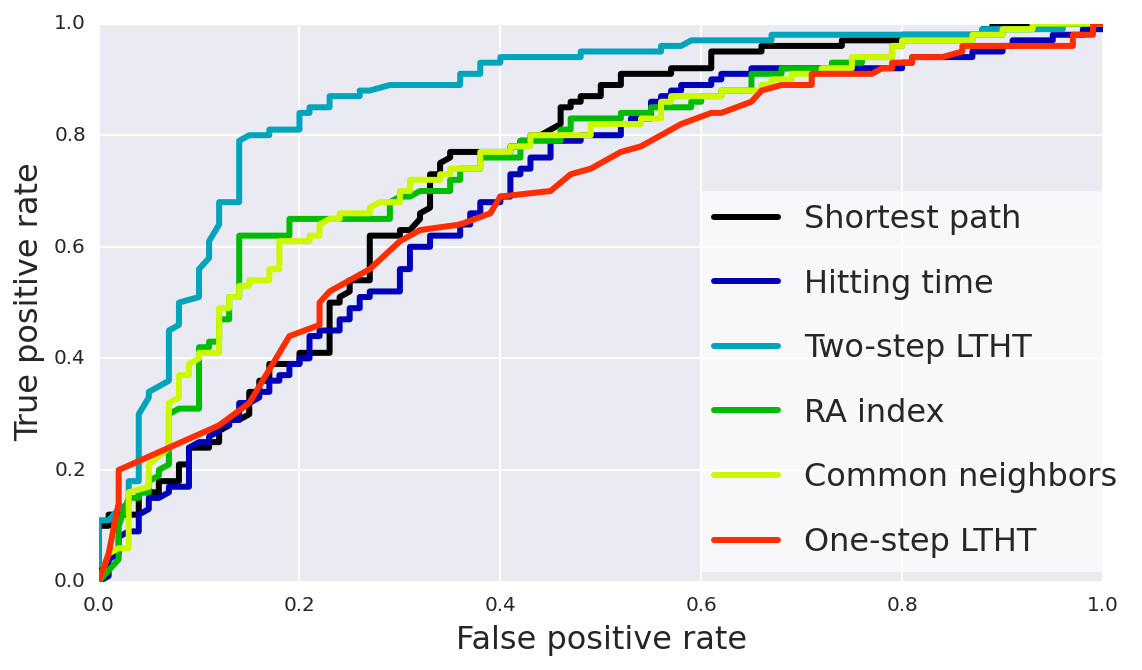

In [36]:
labels=['Shortest path','Hitting time','Two-step LTHT','RA index','Common neighbors','One-step LTHT']
rocs=[metrics.roc_curve(eweights!=1,-rmat[:,i]) for i in xrange(6)]
cols=plt.get_cmap('spectral')(np.arange(6)/6.0)
plt.figure(figsize=(9,5))
for i in xrange(6):
    plt.plot(rocs[i][0],rocs[i][1],c=cols[i,:],label=labels[i],linewidth=3)

frame = plt.legend(bbox_to_anchor=(0.60, 0.7), loc=2, borderaxespad=0.,fontsize=16, frameon=1,labelspacing=1.05).get_frame()
frame.set_facecolor('white')
frame.set_alpha(0.7)
plt.xlabel('False positive rate',fontsize=16)
plt.ylabel('True positive rate',fontsize=16)

###LTHT allowing T=1

In [37]:
rmat2 = np.zeros((len(edgesamp), 5))

In [38]:
for edgesel in xrange(len(edgesamp)):
    if edgesel % 10 == 0:
        print edgesel
    ccopy = bigcluster.copy()
    
    orig = edgelist[edgesamp[edgesel]][0]
    target = edgelist[edgesamp[edgesel]][1]
    
    rmid = ccopy.get_eid(orig,target)
    #ccopy.delete_edges(rmid)
    nbs = ccopy.neighborhood()

    hittimes = fast_hit_time(orig,nsamples,runtime, nbs)
    
    weighthit1 = -np.log(np.dot(hittimes,np.exp(-beta*np.arange(runtime)))/nsamples 
                        + np.exp(-beta*runtime) * (nsamples-np.sum(hittimes,1))/nsamples)

    ccopy = bigcluster.copy()
    
    orig = edgelist[edgesamp[edgesel]][0]
    target = edgelist[edgesamp[edgesel]][1]
    
    rmid = ccopy.get_eid(orig,target)
    ccopy.delete_edges(rmid)
    nbs = ccopy.neighborhood()
    hittimes = fast_hit_time(orig,nsamples,runtime, nbs)
    
    weighthit2 = -np.log(np.dot(hittimes,np.exp(-beta*np.arange(runtime)))/nsamples 
                        + np.exp(-beta*runtime) * (nsamples-np.sum(hittimes,1))/nsamples)

    rmat2[edgesel,:]=np.array([sp.stats.rankdata(weighthit1)[target]/len(weighthit),
                              sp.stats.rankdata(weighthit2)[target]/len(weighthit),
                              orig,
                              target,
                              len(cneighbors)
                             ])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


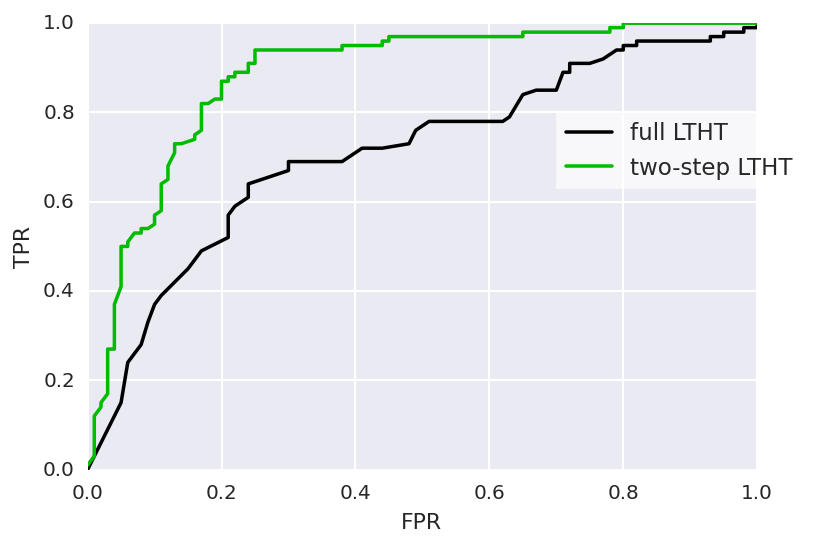

In [39]:
labels=['full LTHT','two-step LTHT']
rocs=[metrics.roc_curve(eweights!=1,-rmat2[:,i]) for i in xrange(2)]
cols=plt.get_cmap('spectral')(np.arange(2)/2.0)
for i in xrange(2):
    plt.plot(rocs[i][0],rocs[i][1],c=cols[i,:],label=labels[i])
frame = plt.legend(bbox_to_anchor=(0.7, 0.8), loc=2, borderaxespad=0.,fontsize=11.5).get_frame()
frame.set_facecolor('white')
frame.set_alpha(0.7)
plt.xlabel('FPR')
plt.ylabel('TPR')

### On synthetic set

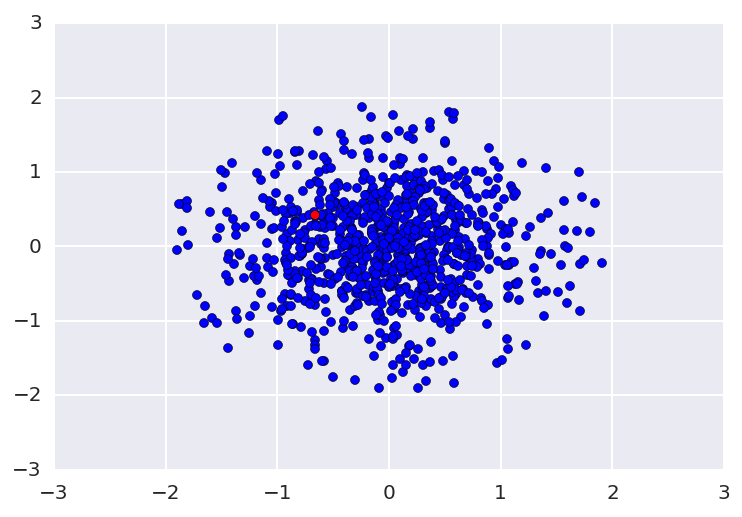

In [40]:
n=3000
k=50
np.random.seed(1)
theta=np.random.uniform(low=0,high=2*math.pi,size=n)

x1 = np.random.normal(loc=0.0,scale=0.5,size=(500,2))
x2 = np.random.normal(loc=0,scale=1.0,size=(500,2))

xc = np.vstack((x1,x2))

xc=xc[np.sum(xc**2,1)<=4,:]

plt.figure()
plt.scatter(xc[:,0],xc[:,1],c='b')
orig=1
plt.scatter(xc[orig,0],xc[orig,1],c='r')

In [41]:
nsamples = 5000
runtime = 50000
nbrs, adjclean = fit_knn(xc, k)
nbclean = adj_to_nblist(adjclean)
nbcleanin = adj_to_nblist(adjclean.T)

In [42]:
hittimes = fast_hit_time(orig, nsamples, runtime, nbclean)

In [43]:
deg = 1.0/(np.sum(adjclean,1)*k)
raindex = np.zeros(xc.shape[0])
for v2 in xrange(xc.shape[0]):
    common_neis = np.intersect1d(nbclean[orig],nbcleanin[v2])
    if len(common_neis) > 0:
        raindex[v2] = np.sum(deg[common_neis])

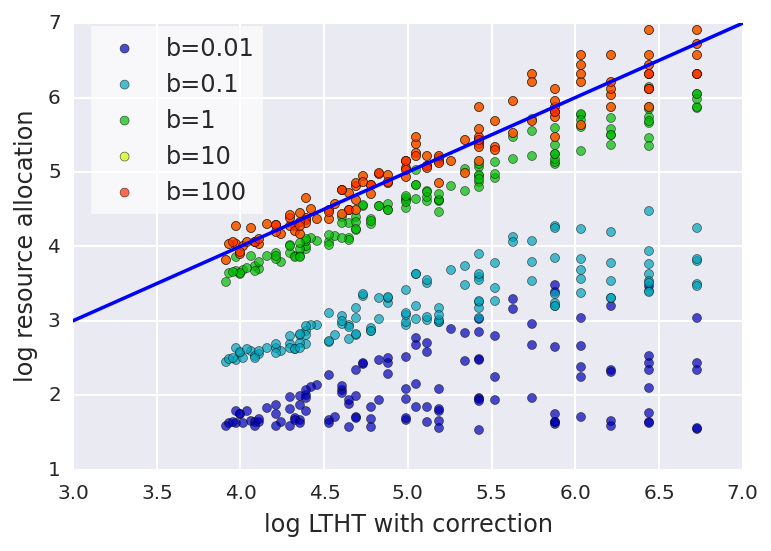

In [44]:
betalist = [ 0.01, 0.1, 1, 10, 100]
hittimes2=hittimes.copy()
hittimes2[:,0]=0

cols=plt.get_cmap('spectral')(np.arange(6)/6.0)
i=0
plt.figure()
for beta in betalist:
    weighthit2 = ltht(hittimes2, beta)-2*beta
    plt.scatter(-np.log(raindex)+np.log(k), weighthit2,c=cols[i+1],alpha=0.7,label='b='+str(beta))
    i=i+1
plt.plot(np.array([2,10]),np.array([2,10]),c='b')
plt.ylabel('log resource allocation',fontsize=12)
plt.xlabel('log LTHT with correction',fontsize=12)
plt.xlim((3,7))
plt.ylim((1,7))
frame = plt.legend(fontsize=12,bbox_to_anchor=(0.3, 1.02)).get_frame()
frame.set_facecolor('white')
frame.set_alpha(0.7)